# Кластеризация

Структура:

1. Краткий конспект теоретической основы  
2. Практика. Базовые алгоритмы кластеризации:      
    - K-means     
    - EM-алгоритм (Expectation-maximization algorithm)     
    - Иерархическая кластеризация (Агломеративная)       
    - DBSCAN

In [2]:
# Подготовка среды и датасетов
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle, islice
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

plt.rcParams['figure.figsize'] = 12, 8

# 1. Краткий конспект теоретической основы

**Кластеризация** — это задача разбиения некоего количества объектов на группы (кластеры), при этом объекты в группах должны иметь что-то общее и сильно отличаться от объектов в других кластерах.   
Кластеризация объектов - это **задача обучения без учителя**.  

**Разные цели кластеризации:**  
- Упростить дальнейшую обработку данных: разбить множество объектов на несколько групп (кластеров), чтобы в дальнейшем работать с каждым кластером в отдельности.  
- Сократить объём хранимых данных: выделить кластеры и оставить по одному объекту (или несколько объектов) от каждого кластера, таким образом сжать данные.  
- Выделить нетипичные объекты - объекты, которые нельзя отнести ни к одному из кластеров.   
- Построить иерархию множества объектов: задача таксономии.

**В задаче кластеризации входные данные задаются двумя способами:**  
- **Признаковое описание объектов**: все объекты описываются некоторыми характеристиками (значениями признаков).  
- **Матрица расстояний между объектами**: для каждого объекта представлены расстояния от него до всех остальных объектов выборки.    

**Разнообразие условий задач кластеризации:**  
- Форма кластеров.  
- Вложенность кластеров друг в друга.  
- Размер кластеров.  
- Кластеризация как основная или вспомогательная задача (например, по результатам кластеризации может проводиться классификация).  
- "Жёсткая" кластеризация (объект относится к конкретному кластеру) или "мягкая" кластеризация (определяется вероятность принадлежности объекта к кластеру).

**Решение задачи кластеризации принципиально неоднозначно:**  
- Сложность точной постановки задачи кластеризации.  
- Существует множество критериев качества кластеризации.  
- Существует множество методов кластеризации.  
- Часто заранее неизвестно число кластеров.  
- Результат кластеризации зависит от метрики, которая задаётся субъективно.  

**C помощью кластеризации можно решать, например, следующие задачи:**  
- сегментация рынка (сегментация клиентов возрасту и т.д.);  
- объединение близких точек на карте;  
- сжатие изображений;  
- детекторы аномального поведения;  
- выделение схожих групп респондентов на основании соцопросов;  
- формирование поведенческих паттернов людей;  
- выделение схожих по экономическим показателям регионов;
- кластеризация текста (новости спорта, политики и т.д);
- сегментация изображений для выделения объектов и др. 

### Рассмотрим несколько наборов данных, к которым будут применяться алгоритмы кластеризации
- три хорошо разделимых кластера; 
- три кластера с добавлением шума; 
- кластеры с ленточной структурой; 
- сложные случаи - вложенные кластеры;    
- отсутствие кластерной структуры.

Проиллюстрируем эти кластеры.

In [21]:
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

# Количество объектов в каждом датасете
n_samples = 1500

# Вписанные круги
noisy_circles = datasets.make_circles(n_samples = n_samples, factor = .5,
                                      noise = .05)
# Оставляем только признаки датасета, так как для кластеризации нам не нужны истинные классы объектов
X, y = noisy_circles
noisy_circles = X

# Полукруги
noisy_moons = datasets.make_moons(n_samples = n_samples, noise = .05)
X, y = noisy_moons
noisy_moons = X

# Кластеры в форме круга
blobs = datasets.make_blobs(n_samples = n_samples, random_state = 8)
X, y = blobs
blobs = X

# Отсутствие кластерной структуры
no_structure = np.random.rand(n_samples, 2)

# Кластеры лентовидной формы
random_state = 170
X, y = datasets.make_blobs(n_samples = n_samples, random_state = random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# Кластеры в форме кругов с различной дисперсией
varied = datasets.make_blobs(n_samples = n_samples, cluster_std = [1.0, 2.5, 0.5], random_state = random_state)
X, y = varied
varied = X

<ipython-input-22-85cd13fd6325>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'23{i}')


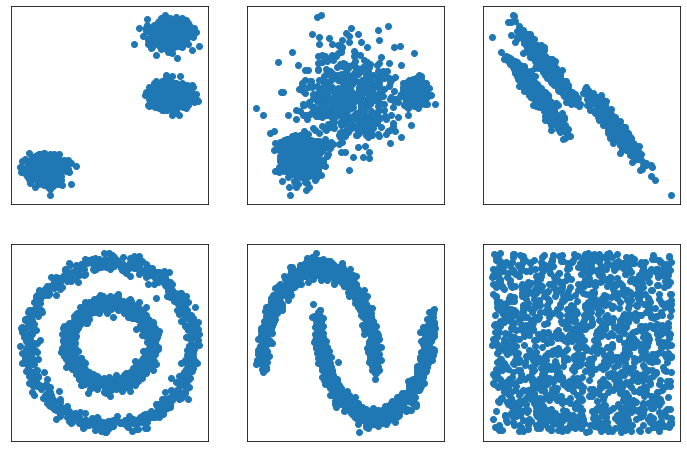

In [22]:
# Визуализируем кластеры
datasets_list = [blobs, varied, aniso, noisy_circles, noisy_moons, no_structure]
for i, X in enumerate(datasets_list, start = 1):
    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    plt.scatter(X[:, 0], X[:, 1])

# 2. Практика. Базовые алгоритмы кластеризации      
  2.1. K-means (Метод k-средних)    
  2.2. EM-алгоритм (Expectation-maximization algorithm)     
  2.3. Иерархическая кластеризация (Агломеративная)     
  2.4. DBSCAN (Dense-based spatial clustering of applications with noise)

## 2.1. K-means  

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">Документация K-means Sklearn</a>     
<a href="https://www.naftaliharris.com/blog/visualizing-k-means-clustering/">Интерактивная визуализация работы KMeans (метода k-средних)</a>  

![KMeans](https://www.jeremyjordan.me/content/images/2016/12/kmeans.gif "KMeans")

**Схема действия алгоритма k-means:**

- выбрать количество кластеров, которое мы считаем оптимальным для наших данных;
- выбрать случайным образом в пространстве данных центроиды;
- для каждой точки набора данных посчитать, к какому центроиду она ближе;
- переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду (каждый центроид на каждой итерации — вектор, элементы которого представляют собой средние значения признаков, вычисленные по всем записям кластера);
- повторять шаги 3-4 фиксированное число раз или до тех пор, пока центроиды не сойдутся.

Основные **недостатки** алгоритма:

- число кластеров необходимо знать заранее;
- алгоритм очень чувствителен к первичному выбору центроидов;
- не гарантирует достижение глобального минимума суммы квадратов расстояний, часто «застревает» в локальном минимуме.  

k-means довольно хорошо работает с небольшим объемом данных.   
У данного алгоритма есть **вариации**, которые применяются в некоторых специфических случаях: Mini-Batch K-means и K-means++.  

**Mini-Batch K-means**. Эта вариация k-means используется в случае, если данных очень много. На каждом шаге алгоритм работает с небольшой подвыборкой данных. В общем случае упрощённый алгоритм должен сходиться к тому же результату, что и на полной выборке.   
Однако исследования показывают, что качество кластеров может ухудшаться по сравнению с классическим k-means.  

**K-means++**. Эта вариация k-means, как правило, используется в том случае, если у нас очень много признаков.  
Как известно, результат и время работы k-means зависит от изначального выбора центров. Чтобы минимизировать затраты, можно действовать следующим образом:  
- первый центр выбирать случайно из равномерного распределения на выборке,  
- каждый следующий центр выбирать случайно из оставшихся точек так, чтобы вероятность выбрать каждую точку была пропорциональна квадрату расстояния от неё до ближайшего центра.

In [133]:
# Создадим модель
k_means = KMeans(n_clusters = 8,    # Число кластеров, на которое алгоритм будет делить набор данных
                init = 'k-means++', # Cпособ начальной инициализации центроидов кластров; 'k-means++', 'random', numpy.array
                max_iter = 300)     # Кол-во итераций

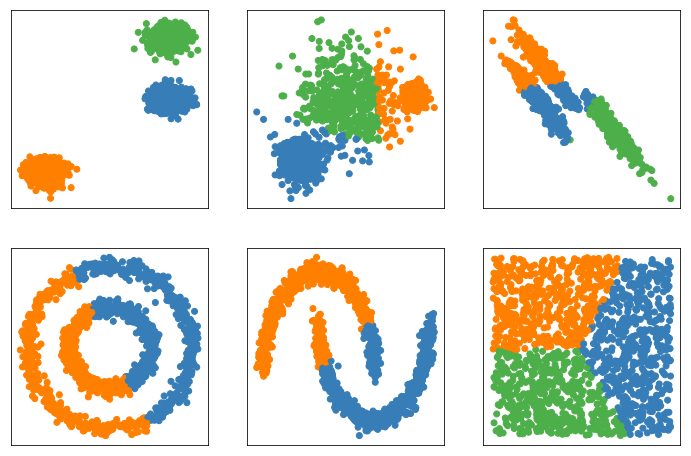

In [26]:
# Создадим массив пар – датасета и соответствующих для него параметров алгоритма
# Нормализуем данные, обучим модель и посмотрим на результат

datasets_params_list = [
    (blobs, {'n_clusters': 3}),
    (varied, {'n_clusters': 3}),
    (aniso, {'n_clusters': 3}),
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (no_structure, {'n_clusters': 3})]

for i, (X, k_means_params) in enumerate(datasets_params_list, start = 1):
    X = StandardScaler().fit_transform(X)
    k_means = KMeans(n_clusters = k_means_params['n_clusters'])
    
    k_means.fit(X)
    y_pred = k_means.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color = colors[y_pred])

- В первом случае алгорим сработал хорошо - идентифицировал три простых кластера.  
- Во втором случае при добавлении шума часть элементов перешла в другой кластер.  
- В последующих примерах алгоритм перепутал кластеры или нашел кластеры там, где их не должно быть.

### Посмотрим на результат работы алгоритма  k_means (метод k-средних).  Сгенерируем датасет, содержащий два признака. В данных содержатся три кластера. 
При использовании переменных X и y будем считать, что эти переменные содержат признаки объектов и классы объектов датасета соответственно. В дальнейших задачах будет также использоваться этот датасет.  

In [320]:
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

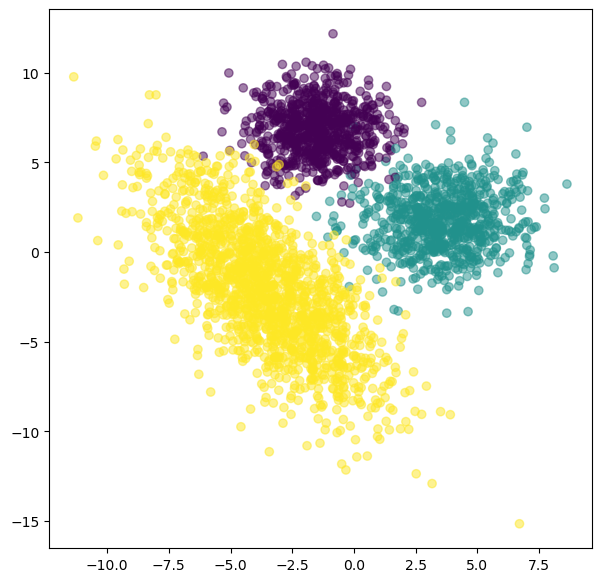

In [322]:
# Визуализируем датасет
plt.rcParams['figure.figsize'] = 7, 7
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

In [323]:
# Посмотрим распределение классов в датасете:
unique, counts = np.unique(y, return_counts = True)
dict(zip(unique, counts))

{0: 750, 1: 750, 2: 1500}

- **Обучим алгоритм K-means с параметрами n_clusters=3 и random_state=42 на признаках исходного датасета.**  
- **Посмотрим, какие центроиды будут у получившихся кластеров и подсчитаем количество элементов в каждом из кластеров.**

In [324]:
k_means = KMeans(n_clusters = 3, random_state = 42).fit(X)
display(k_means.cluster_centers_)
print(np.round(k_means.cluster_centers_).astype('int'))

# Подсчитаем количество элементов в каждом из кластеров
cl, counts = np.unique(k_means.labels_, return_counts = True)
for count in counts:
    print(count, end = '  ')

array([[-3.18996384, -2.90484307],
       [-2.38363475,  6.23391526],
       [ 3.6296089 ,  1.74479425]])

[[-3 -3]
 [-2  6]
 [ 4  2]]
1320  938  742  

C:\Users\user\AppData\Local\Temp\ipykernel_14180\2705272850.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.round(k_means.cluster_centers_).astype(np.int))


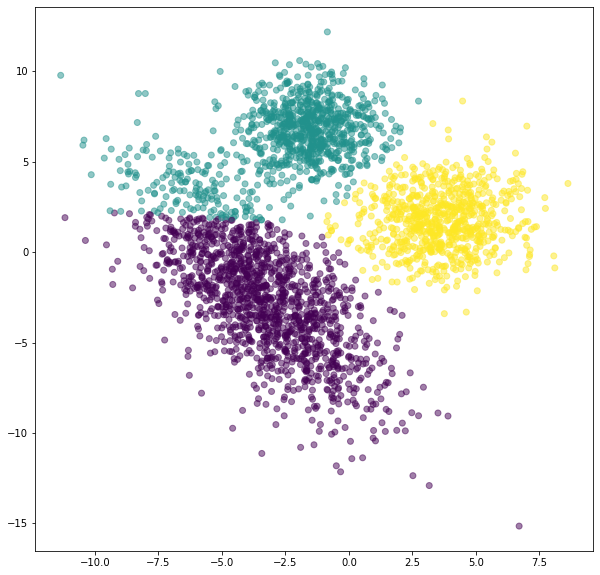

In [264]:
# Применим средства визуализации
k_means_pred = k_means.labels_
plt.scatter(X[:, 0], X[:, 1], c = k_means_pred, alpha = 0.5)
plt.show()

### K-Means для кластеризации учеников средней школы в зависимости от их интересов  
- В датасете предоставлены следующие признаки: год выпуска, пол, возраст, количество друзей, 36 ключевых слов, которые встречаются в профилe Facebook (интересы, сообщества, встречи).   
- Выделим кластеры исключительно по интересам. Удалим все признаки, кроме ключевых слов.

In [368]:
pupils = pd.read_csv('snsdata.csv')
display(pupils.head())
display(pupils.info())

# Оставим в качестве признаков только ключевые слова, остальные удалим
pupils = pupils.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1)
print(f'Признаки: \n{pupils.columns}')

# Нормализуем оставшиеся признаки при помощи StandardScaler 
X = pupils.values
X = StandardScaler().fit_transform(X)

# Используем метод k-means для кластеризации 
k_means_pupils = KMeans(n_clusters = 9, random_state = 123).fit(X)
print(f'\nМодель: {k_means_pupils}')
print(f'Лейблы: {k_means_pupils.labels_}')

# Посмотрим, в какой кластер попало меньше всего учеников
label, counts = np.unique(k_means_pupils.labels_, return_counts = True)
label_counts_dict = dict(zip(label, counts))
print(f'\nМеньше всего учеников попало в кластер: {min(label_counts_dict.items(), key = lambda x: x[1])[0]}')  
# sorted(label_counts_dict.items(), key = lambda x : x[1])[0]

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gradyear      30000 non-null  int64  
 1   gender        27276 non-null  object 
 2   age           24914 non-null  float64
 3   friends       30000 non-null  int64  
 4   basketball    30000 non-null  int64  
 5   football      30000 non-null  int64  
 6   soccer        30000 non-null  int64  
 7   softball      30000 non-null  int64  
 8   volleyball    30000 non-null  int64  
 9   swimming      30000 non-null  int64  
 10  cheerleading  30000 non-null  int64  
 11  baseball      30000 non-null  int64  
 12  tennis        30000 non-null  int64  
 13  sports        30000 non-null  int64  
 14  cute          30000 non-null  int64  
 15  sex           30000 non-null  int64  
 16  sexy          30000 non-null  int64  
 17  hot           30000 non-null  int64  
 18  kissed        30000 non-nu

None

Признаки: 
Index(['basketball', 'football', 'soccer', 'softball', 'volleyball',
       'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute',
       'sex', 'sexy', 'hot', 'kissed', 'dance', 'band', 'marching', 'music',
       'rock', 'god', 'church', 'jesus', 'bible', 'hair', 'dress', 'blonde',
       'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'die',
       'death', 'drunk', 'drugs'],
      dtype='object')

Модель: KMeans(n_clusters=9, random_state=123)
Лейблы: [4 0 4 ... 4 4 4]

Меньше всего учеников попало в кластер: 5


In [370]:
label_counts_dict

{0: 5036, 1: 1337, 2: 752, 3: 697, 4: 20024, 5: 1, 6: 846, 7: 466, 8: 841}

## 2.2. EM-алгоритм (Expectation-maximization algorithm)  

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html">Документация EM-алгоритма Sklearn</a>  
Интерактивная визуализация работы EM-алгоритма

![EM-алгоритм](https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif "EM-алгоритм")


**Суть работы EM-алгоритма:**

- выбираем количество кластеров, которое мы считаем оптимальным, в данном случае их два;
- выбираем параметры распределений каждого кластера;
- для каждой точки набора данных считаем вероятность принадлежности к каждому распределению (кластру);
- пересчитываем параметры распределения таким образом, чтобы максимизировать вероятность принадлежности точек, отнесённых к кластеру;
- повторяем шаги: снова присваиваем точку распределению и считаем, обновляем параметры;  
- в результате получаем вероятность принадлежности объекта к кластеру.

EM-алгоритм определяет смеси распределений в выборке, а не просто проводит кластеризацию.  

На картинке изображена смесь трех нормальных распределений:    

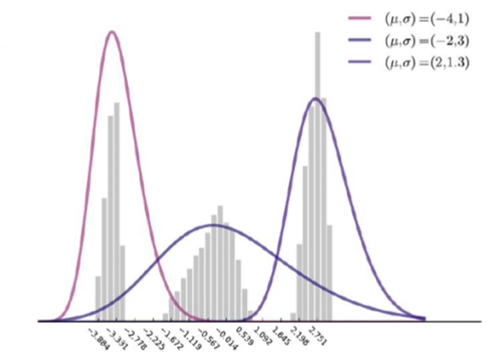

**Техничсекие характеристики алгоритма**  
- Плотность распределения признаков объекта x:  
  (сумма весов, которые мы изначально инициализировали умноженная на плотность вероятности конкретного кластера):  
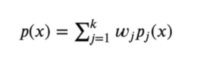  
- Плотность вероятности конкретного кластера (функция Ф с параметрами):
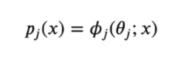   
- E-шаг (expectation) - вычисление ожидаемого кластера для каждого объекта:  
  (получаем плотность вероятности того, что данная точка лежит в том или ином кластере)
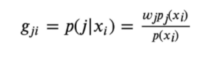    
- M-шаг (maximization) - оценка веса и параметров распределения для каждого кластера:  
  (оцениваем вес каждого кластера - он зависит от того, сколько точек в него попало с той или иной вероятностью - и максимизируем параметры, чтобы точки, которые попали в кластер на предыдущем шаге, были в нем с бОльшей вероятностью)
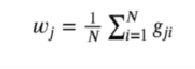  
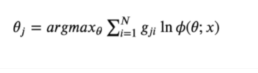  

**EM-алгоритм (вкратце):**  
- Выбираем "скрытые переменные", чтобы с их помощью было проще максимизировать правдоподобие.  
- E-шаг (expectation) - оцениваем скрытые переменные.
- M-шаг (maximization) - оцениваем веса и плотности вероятности для каждого кластера, фиксируя скрытые переменные. 

Основные **преимущества** алгоритма:

- эффективная обработка больших объемов данных;
- мощная статистическая основа;
- устойчивость к шуму и пропускам в данных;
- возможность построения желаемого кол-ва кластеров;
- быстрая сходимость при удачной инициализации.  

Основные **недостатки** алгоритма:

- при неудачной инициализации сходимость алгоритма может оказаться медленной;
- предположение о нормальности всех измерений данных не всегда выполняется;
- алгоритм иногда останавливается в локальном минимуме и не достигает глобального.

In [321]:
# Создадим модель
em_gm = GaussianMixture(n_components = 1, 
                        max_iter = 100,
                        init_params = 'kmeans' 
                       )

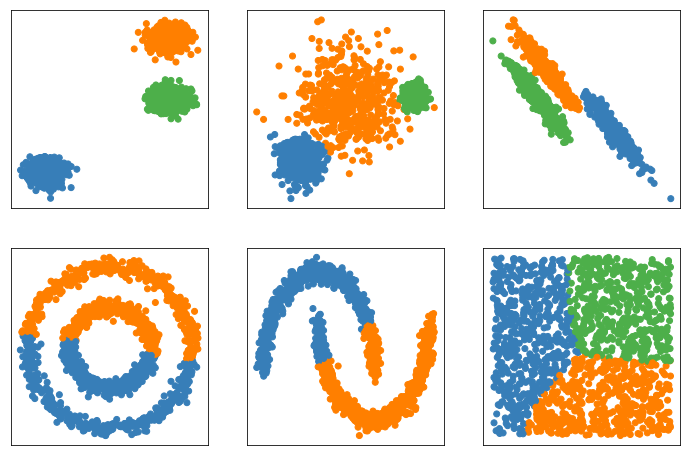

In [28]:
# Создаём массив пар – датасета и соответствующих для него параметров алгоритма. 
# Нормализуем данные, обучим модель, сделаем предсказание и построим получившиеся кластеры для наших датасетов

datasets_params_list = [
    (blobs, {'n_clusters': 3}),
    (varied, {'n_clusters': 3}),
    (aniso, {'n_clusters': 3}),
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (no_structure, {'n_clusters': 3})]

for i, (X, em_gm_params) in enumerate(datasets_params_list, start = 1):
    X = StandardScaler().fit_transform(X)
    em_gm = GaussianMixture(n_components = em_gm_params['n_clusters'])
    
    em_gm.fit(X)
    y_pred = em_gm.predict(X)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color = colors[y_pred])

- В результате простые кластеры разделились хорошо.   
- В примере, где добавлен шум, EM-алгоритм справился лучше, чем k-means.  
- Алгоритм обнаружил ленточную структуру.   
- С более сложными примерами алгоритм не справился и нашёл кластеры там, где их не должно было быть.

### Посмотрим на результат работы EM-алгоритма. Используем сгенерированный датасет с двумя признаками. В данных содержатся три кластера.

In [295]:
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

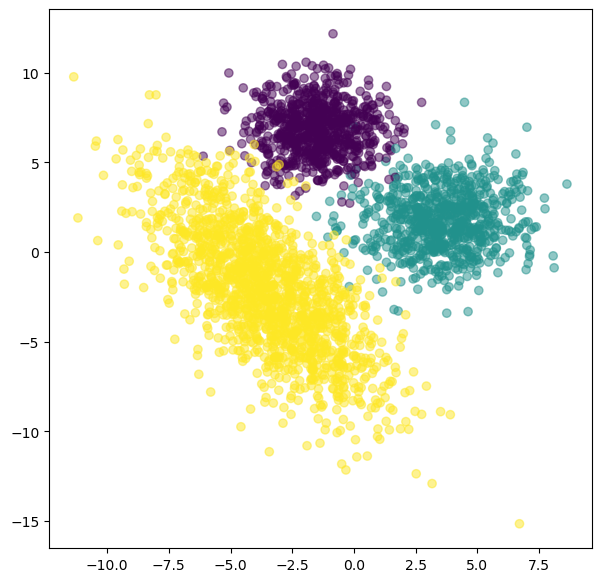

In [296]:
# Визуализируем датасет
plt.rcParams['figure.figsize'] = 7, 7
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

In [297]:
# Посмотрим распределение классов в датасете
unique, counts = np.unique(y, return_counts = True)
dict(zip(unique, counts))

{0: 750, 1: 750, 2: 1500}

 - **Обучим алгоритм GaussianMixture с параметрами n_components=3 и random_state=42 на признаках исходного датасета.**  
 - **Посмотрим на средние значения распределений кластеров.**

In [24]:
gm = GaussianMixture(n_components = 3, random_state = 42)
y_pred = gm.fit_predict(X)
print(np.round(gm.means_).astype('int'))

[[-2  7]
 [-4 -2]
 [ 4  2]]


In [25]:
# Подсчитаем количество элементов в каждом из получившихся кластеров
cluster, counts = np.unique(y_pred, return_counts = True)
for count in counts:
    print(count, end = ' ')

763 1493 744 

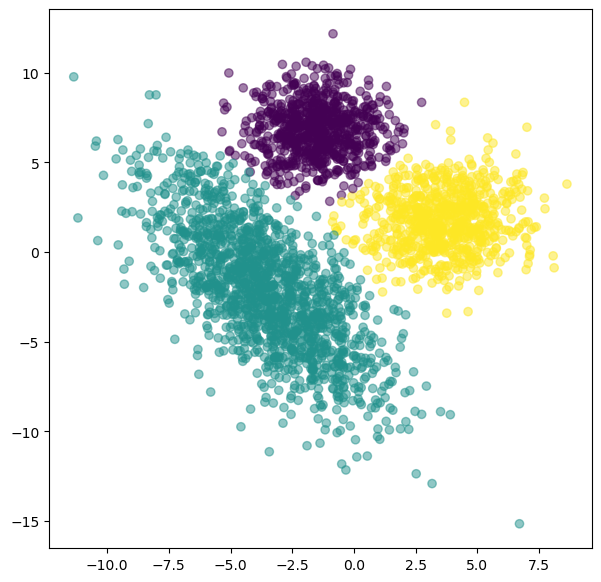

In [26]:
# Применим средства визуализации
plt.rcParams['figure.figsize'] = 7, 7
plt.scatter(X[:, 0], X[:, 1], c = y_pred, alpha = 0.5)
plt.show()

### EM-алгритм  для кластеризации учеников средней школы в зависимости от их интересов

Возьмём данные про учеников старшей школы из прошлого датасета (pupils) c такой же обработкой и применим к ним EM-алгоритм, количество кластеров — 9, random_state = 123. Посмотрим на результаты.

In [41]:
pupils.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [48]:
# Нормализуем данные, обучим модель и сделаем предсказание
X = pupils.values
X = StandardScaler().fit_transform(X)

gm_puplis = GaussianMixture(n_components = 9, random_state = 123)
y_pred_pupils = gm_puplis.fit_predict(X)

# Посмотрим, к какому кластеру принадлежит восьмой (по списку из изначального датасета) ученик
print(f'Восьмой (по списку из изначального датасета) ученик принадлежит к {y_pred_pupils[7]} кластеру.')

# Посмотрим, сколько итераций до схождения осуществил алгоритм
print(f'Алгоритм осуществил {gm_puplis.n_iter_} итерации.')

Восьмой (по списку из изначального датасета) ученик принадлежит к 3 кластеру.
Алгоритм осуществил 23 итерации.


## 2.3. Иерархическая кластеризация (Агломеративная) 

![AG](https://media.giphy.com/media/pSNCWCEAsgrAs/giphy.gif "Агломеративная кластеризация")


<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html">Документация AgglomerativeClustering Sklearn</a> 

**Иерархическая кластеризация** делится на две стратегии: 
- **агломеративная** — объединяем точки в кластеры (снизу-вверх); 
- **дивизионная** — разделяем один большой кластер на малые (сверху-вниз).

**Агломеративная кластеризация:** 
- назначаем каждой точке свой кластер; 
- сортируем попарные расстояния между центрами кластеров по возрастанию;
- берём пару ближайших кластеров, соединяем их в один и пересчитываем центр кластера;
- повторяем шаги 2-3 до тех пор, пока все данные не сойдутся в один кластер.

**Расстояние между кластерами.**   
Поиск ближайших кластеров можно осуществлять с помощью разных методов объединения точек:  
- Расстояние ближнего соседа:  
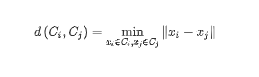  
- Расстояние дальнего соседа:  
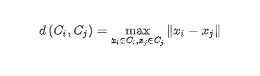  
- Групповое среднее расстояние:  
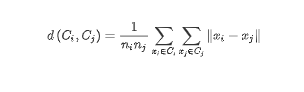  
- Расстояние между центрами:  
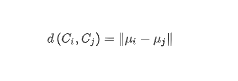  
- Формула Ланса-Уильямса:  
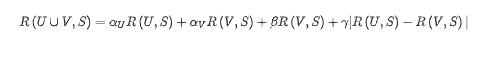  
- Расстояние Уорда:  
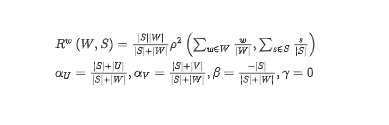

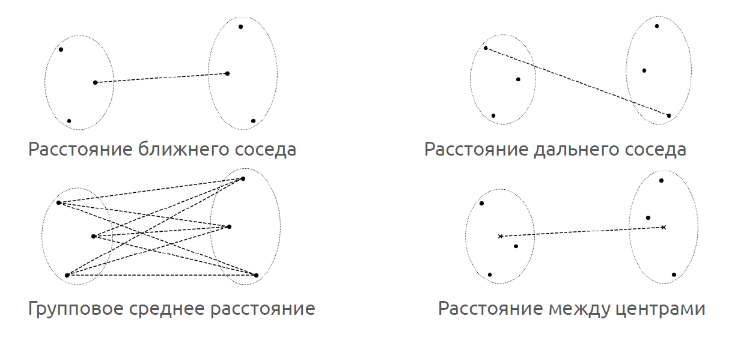

In [23]:
ac = AgglomerativeClustering(n_clusters = 2,
                             affinity = 'euclidean',    # 'euclidean', l1, l2, 'manhattan', 'cosine', or 'precomputed'
                             linkage = 'ward')          # 'ward', 'complete', 'average', 'single'

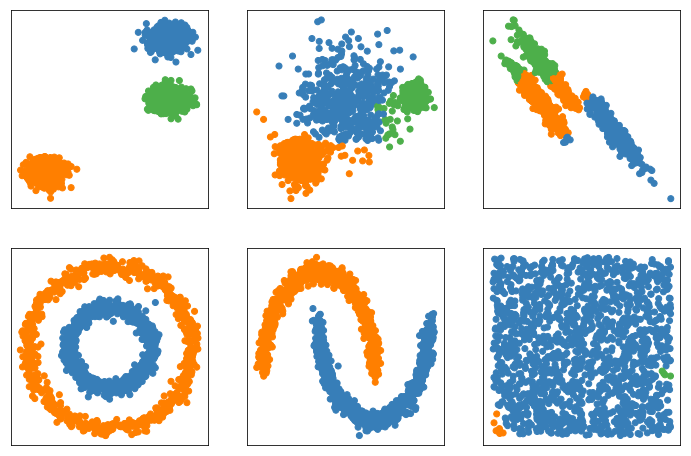

In [30]:
import warnings
from sklearn.neighbors import kneighbors_graph

datasets_params_list = [
    (blobs, {'n_clusters': 3, 'n_neighbors': 10}),
    (varied, {'n_clusters': 3, 'n_neighbors': 2}),
    (aniso, {'n_clusters': 3, 'n_neighbors': 2}),
    (noisy_circles, {'n_clusters': 2, 'n_neighbors': 10}),
    (noisy_moons, {'n_clusters': 2, 'n_neighbors': 10}),
    (no_structure, {'n_clusters': 3, 'n_neighbors': 10})]

for i, (X, ac_params) in enumerate(datasets_params_list, start = 1):
    X = StandardScaler().fit_transform(X)  # нормализуем признаки
    
    # строим матрицу смежности
    connectivity = kneighbors_graph(X, 
                                    n_neighbors = ac_params['n_neighbors'], 
                                    include_self = False)
    # делаем матрицу смежности симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ac = AgglomerativeClustering(n_clusters = ac_params['n_clusters'], 
                                 linkage = 'average',
                                 connectivity = connectivity)
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message = "the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category = UserWarning)
        ac.fit(X)
    y_pred = ac.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color = colors[y_pred])

- В результате агломеративная кластеризация хорошо справилась с простыми кластерами.   
- Со сложными кластерами этот алгоритм справился лучше, чем EM-алгоритм. С ленточными кластерами, наоборот, хуже.  
- Агломеративная кластеризация более явно определила отсутствие кластерной структуры.

### Посмотрим на результат работы иерархической (агломеративной) кластеризации. Используем сгенерированный датасет c двумя признаками. В данных содержатся три кластера.

In [2]:
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

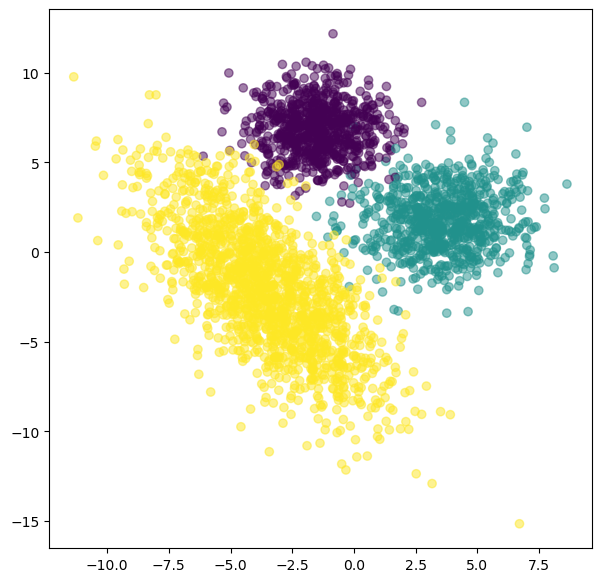

In [3]:
# Визуализируем датасет
plt.rcParams['figure.figsize'] = 7, 7
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

In [4]:
# Посмотрим распределение классов в датасете
unique, counts = np.unique(y, return_counts = True)
dict(zip(unique, counts))

{0: 750, 1: 750, 2: 1500}

- **Обучим модель AgglomerativeClustering с параметром n_clusters=3 на признаках исходного датасета.**  
- **Посмотрим число листьев в иерархическом дереве, полученном при обучении.**

In [5]:
ac_2 = AgglomerativeClustering(n_clusters = 3)
ac_2.fit(X)
display(ac_2.labels_)
print(f'Число листьев в иерархическом дереве, полученном при обучении: {ac_2.n_leaves_}')

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

Число листьев в иерархическом дереве, полученном при обучении: 3000


1112 1142 746 

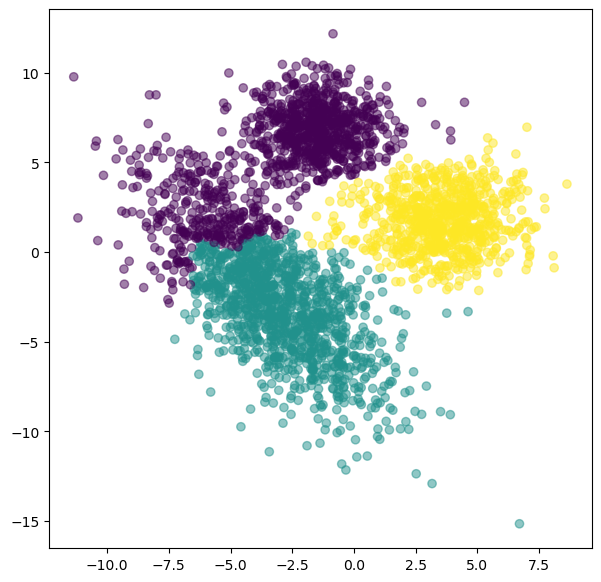

In [6]:
# Подсчитаем количество элементов в каждом из кластеров
cl, counts = np.unique(ac_2.labels_, return_counts = True)
for count in counts:
    print(count, end = ' ')
    
# Применим средства визуализации
plt.rcParams['figure.figsize'] = 7, 7
ac_2_pred = ac_2.labels_
plt.scatter(X[:, 0], X[:, 1], c = ac_2_pred, alpha = 0.5)
plt.show()

При создании модели *AgglomerativeClustering* можно указать **матрицу смежности**, передав её в параметр **connectivity**.    
В переменной connectivity будет хранится матрица смежности для ненаправленного графа на основе датасета.   
**Матрица смежности** — это матрица, которая соответствует графу и отражает, с какими соседями объект связан или не связан.  

- **Обучим модель с параметром n_clusters=3 и составленной матрицей смежности на признаках исходного датасета.**   
- **Подсчитаем количество элементов в каждом из получившихся кластеров.**

In [7]:
# Матрица смежности
connectivity = kneighbors_graph(X, n_neighbors = 6, include_self = False)
connectivity = 0.5 * (connectivity + connectivity.T)

# обучим модель с матрицей смежности и посмотрим результаты
ac_3 = AgglomerativeClustering(n_clusters = 3, connectivity = connectivity)
ac_3.fit(X)
ac_3.labels_

array([1, 1, 2, ..., 0, 0, 0], dtype=int64)

1486 746 768 

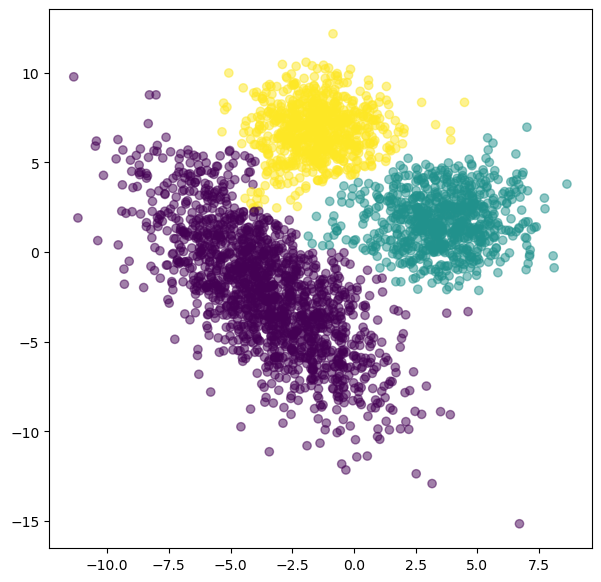

In [9]:
cl, counts = np.unique(ac_3.labels_, return_counts=True)
for count in counts:
    print(count, end = ' ')
    
# Применим средства визуализации
plt.rcParams['figure.figsize'] = 7, 7
ac_3_pred = ac_3.labels_
plt.scatter(X[:, 0], X[:, 1], c = ac_3_pred, alpha = 0.5)
plt.show()    

### Иерархическая кластеризация на основе датасета с информацией о составе различных продуктов

,Name,Energy,Protein,Fat,Calcium,Iron
0,Braised beef,340,20,28,9,2.6
1,Hamburger,245,21,17,9,2.7
2,Roast beef,420,15,39,7,2.0
3,Beefsteak,375,19,32,9,2.6
4,Canned beef,180,22,10,17,3.7


Размер датасета: (27, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Name     27 non-null     object 
 1   Energy   27 non-null     int64  
 2   Protein  27 non-null     int64  
 3   Fat      27 non-null     int64  
 4   Calcium  27 non-null     int64  
 5   Iron     27 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.4+ KB


None

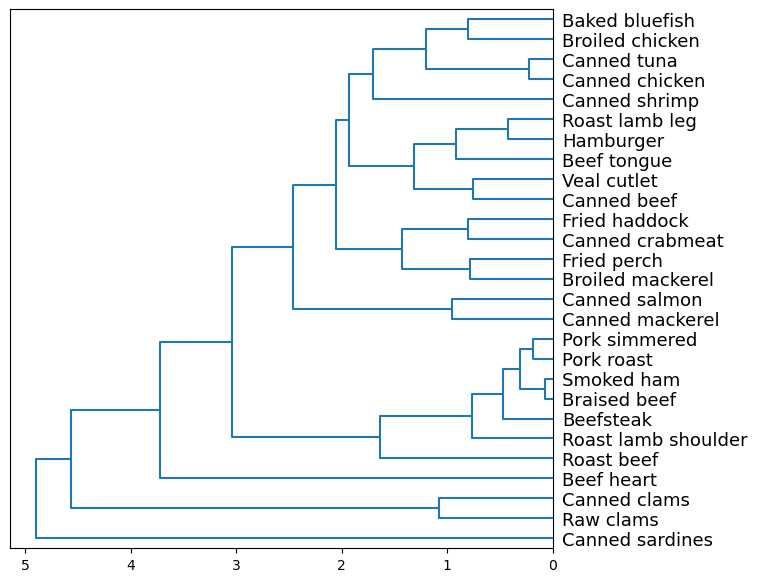

In [13]:
# Загрузим датасет и посмотрим на данные
food = pd.read_csv('food.txt', sep = ' ')
display(food.head())
print(f'Размер датасета: {food.shape}\n')
display(food.info())

# Подготовим данные, проведем нормализацию признаков
X = food.iloc[:, 1:].values
X = StandardScaler().fit_transform(X)

# Построим дендрограмму
fig, axes = plt.subplots(figsize = (7, 7))
Z = linkage(X, method = 'average', metric = 'euclidean')
names = food.Name.values
dend = dendrogram(Z, color_threshold = 0, labels = names, 
                  orientation = 'left', leaf_font_size = 13)

In [14]:
from scipy.cluster.hierarchy import fcluster

t = 2.3
labels = fcluster(Z, t, criterion = 'distance')

# Посмотрим, сколько всего кластеров получилось для продуктов
print(f'Количество кластеров: {len(np.unique(labels))}. Кластеры: {np.unique(labels)}')

# Соединим исходный датасет с лейблами
df_new_food = pd.concat([food, pd.DataFrame(labels, columns = ['label'])], axis = 1)
display(df_new_food.head())

# Посмотрим номер кластера, в который попали продукты с содержанием кальция от 150 до 160.
query_1 = df_new_food[(df_new_food['Calcium'] >= 150) & (df_new_food['Calcium'] <= 160)].label.iloc[0]
print(f'Номер кластера, в который попали продукты с содержанием кальция от 150 до 160: {query_1}')

# Введем номер кластера, в который попал продукт с максимальной жирностью
query_2 = df_new_food[df_new_food.Fat == df_new_food.Fat.max()]['label'].iloc[0]
print(f'Номер кластера, в который попал продукт с максимальной жирностью: {query_2}')

Количество кластеров: 6. Кластеры: [1 2 3 4 5 6]


,Name,Energy,Protein,Fat,Calcium,Iron,label
0,Braised beef,340,20,28,9,2.6,2
1,Hamburger,245,21,17,9,2.7,4
2,Roast beef,420,15,39,7,2.0,2
3,Beefsteak,375,19,32,9,2.6,2
4,Canned beef,180,22,10,17,3.7,4


Номер кластера, в который попали продукты с содержанием кальция от 150 до 160: 3
Номер кластера, в который попал продукт с максимальной жирностью: 2


## 2.4. DBSCAN

<a href="https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/">Интерактивная визуализация работы DBSCAN</a>  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">Документация DBSCAN Sklearn</a> 

![DBSCAN](https://media0.giphy.com/media/lCL2GQewp7fkk/giphy.gif "DBSCAN")

**DBSCAN (Dense-based spatial clustering of applications with noise)** - основанная на плотности пространственная кластеризация для приложений с шумами.  

**Главная идея:**  
- Основные точки.  
- Граничные точки.  
- Шумовые точки.

**Схема действия алгоритма DBSCAN:**  
    1. Случайно выбираем точку, которую не посещали. Окрестность точки извлекается с использованием расстояния (epsilon).    
    2. Если в этой окрестности точек ≥ minPoints, тогда точка становится первой точкой в новом кластере. Иначе — помечаем точку как шум, она становится посещённой.  
    3. Точки из окрестности становятся частью кластера. Для каждой из них изучаем окрестность: если точек в окрестности < minPoints, то помечаем точку как граничную.  
    4. Повторяем пункты 2 и 3, пока не определим все точки в кластере.  
    5. Повторяем пункты 1–4, пока все точки не станут просмотренными.

Оснвные **достоинства** алгоритма:

- не требуется число кластеров;
- определяет кластеры произвольной формы;
- определяет шум, устойчив к выбросам.

Основные **недостатки** алгоритма:

- не может выделять кластеры, имеющие разную плотность;
- результат зависит от используемой функции расстояния.

In [198]:
dbscan = DBSCAN(eps = 0.5,
                min_samples = 5)

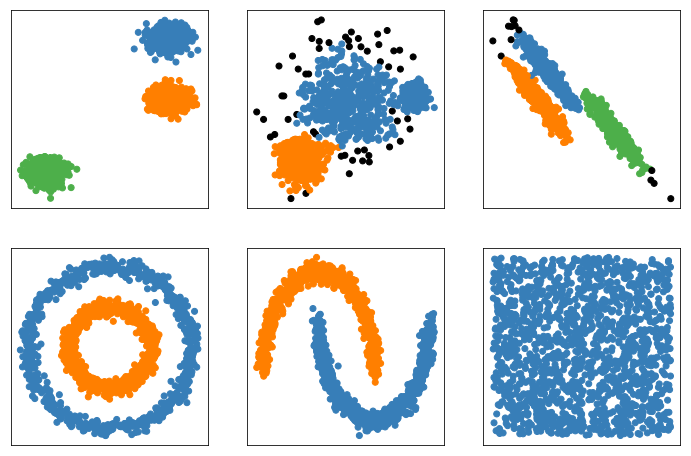

In [32]:
datasets_params_list = [
    (blobs, {'eps': 0.3}),
    (varied, {'eps': 0.18}),
    (aniso, {'eps': 0.184}),
    (noisy_circles, {'eps': 0.3}),
    (noisy_moons, {'eps': 0.3}),
    (no_structure, {'eps': 0.3})]

for i, (X, dbscan_params) in enumerate(datasets_params_list, start = 1):
    X = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps = dbscan_params['eps'])
    
    dbscan.fit(X)
    y_pred = dbscan.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # чёрным цветом отметим выбросы
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], color = colors[y_pred])

- В результате при хорошо разделимых кластерах DBSCAN справился отлично.  
- Алгоритм определил сложные случаи и ленточную структуру, правда, нашёл лишние выбросы.   
- Это единственный алгоритм, по сравнению с предыдущими, который определил, что кластерной структуры в крайнем датасете нет. 
- Добавление шума сбивает алгоритм: во втором примере кластеры склеились между собой.

### Посмотрим на результат работы алгоритма DBSCAN. Используем сгенерированный датасет с двумя признаками. В данных содержатся три кластера.

In [43]:
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

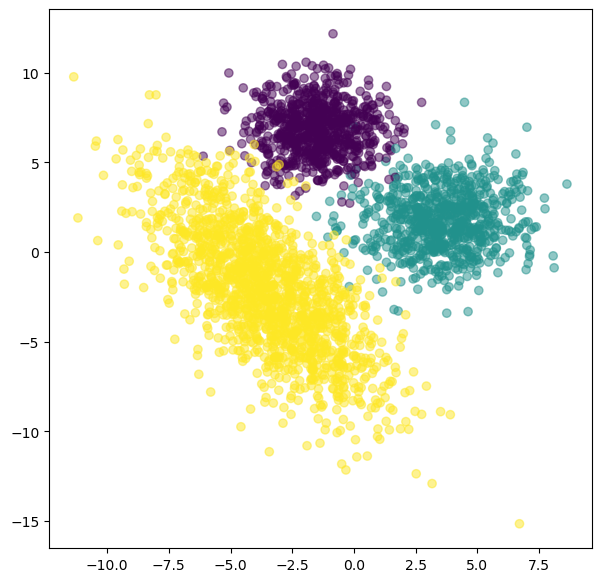

In [309]:
# Визуализируем датасет
plt.rcParams['figure.figsize'] = 7, 7
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

In [310]:
# Посмотрим распределение классов в датасете
unique, counts = np.unique(y, return_counts = True)
dict(zip(unique, counts))

{0: 750, 1: 750, 2: 1500}

#### Обучим модель DBSCAN с параметром eps=0.9 и min_samples=35 на признаках объектов исходного датасета и посмотрим число получившихся кластеров.

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

[array([-1,  0,  1,  2], dtype=int64),
 array([ 368,  656,  721, 1255], dtype=int64)]

Количество элементов в каждом из кластеров: {-1: 368, 0: 656, 1: 721, 2: 1255}


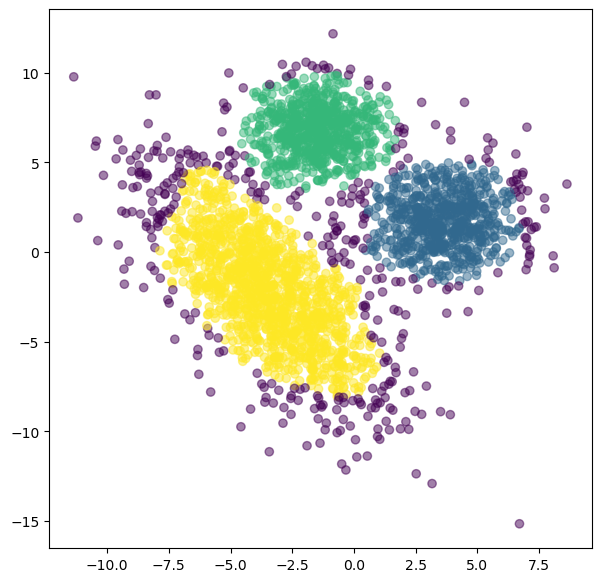

In [318]:
dbscan = DBSCAN(eps = 0.9, min_samples = 35).fit(X)
display(dbscan.labels_)

# Подсчитаем количество элементов в каждом из кластеров
labels_coun_dict = {}
display(list(np.unique(dbscan.labels_, return_counts = True)))
for i in range(len(np.unique(dbscan.labels_))):
    labels_coun_dict.update({np.unique(dbscan.labels_, return_counts = True)[0][i]: 
                             np.unique(dbscan.labels_, return_counts = True)[1][i]})
print(f'Количество элементов в каждом из кластеров: {labels_coun_dict}')

# Применим средства визуализации
plt.rcParams['figure.figsize'] = 7, 7
dbscan_pred = dbscan.labels_
plt.scatter(X[:, 0], X[:, 1], c = dbscan_pred, alpha = 0.5)
plt.show()

#### Обучим модель DBSCAN с параметрами eps=0.8 и min_samples=35 объектах исходного датасета.

[array([-1,  0,  1,  2], dtype=int64),
 array([ 583,  603,  681, 1133], dtype=int64)]

Количество элементов в каждом из кластеров: {-1: 583, 0: 603, 1: 681, 2: 1133}


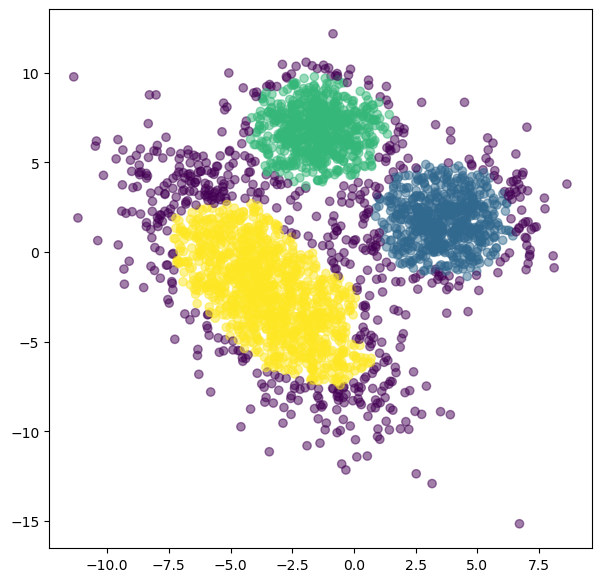

In [319]:
dbscan_2 = DBSCAN(eps = 0.8, min_samples = 35).fit(X)

# Подсчитаем количество элементов в каждом из кластеров
display(list(np.unique(dbscan_2.labels_, return_counts = True)))
unique, counts = np.unique(dbscan_2.labels_, return_counts = True)
labels_coun_dict = dict(zip(unique, counts))
print(f'Количество элементов в каждом из кластеров: {labels_coun_dict}')

n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Применим средства визуализации
plt.rcParams['figure.figsize'] = 7, 7
dbscan_pred = dbscan_2.labels_
plt.scatter(X[:, 0], X[:, 1], c = dbscan_pred, alpha = 0.5)
plt.show()

## Сравнение алгоритмов

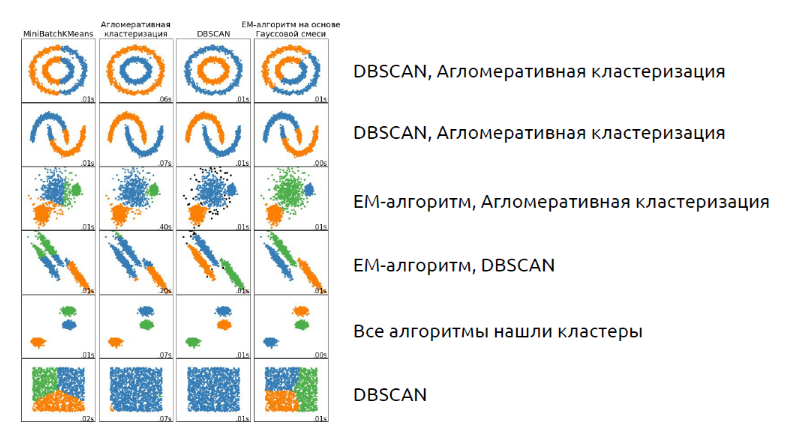